<a href="https://www.kaggle.com/code/stutiiikatariaaa/notebook44ce8af5df?scriptVersionId=239408893" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 52.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.4 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=8bce983e7b333be13c1ff5b30c85097ac5dfb59e1bf543e1073d7568ff475f0f
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from typing import Dict, List, Optional, Sequence, Tuple
import collections
import datetime
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi

from IPython import display
from matplotlib import pyplot as plt
import seaborn as sns

2025-05-04 09:23:53.610734: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746350633.789075      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746350633.840550      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

_SAMPLING_RATE = 16000

In [4]:
import pathlib
import glob

data_dir = pathlib.Path('/kaggle/input/maestro-v1-0-0-midi')

filenames = glob.glob(str(data_dir / '**/*.mid*'), recursive=True)

print('Number of files:', len(filenames))


Number of files: 1184


In [5]:
# analyzing and working with a sample file

sample_file = filenames[1]
print(sample_file)

pm = pretty_midi.PrettyMIDI(sample_file)

print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

# Extracting the notes
for i, note in enumerate(instrument.notes[:10]):
    note_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    print(f'{i}: pitch={note.pitch}, note_name={note_name}, duration={duration:.4f}')

/kaggle/input/maestro-v1-0-0-midi/maestro-v1.0.0/2017/MIDI-Unprocessed_060_PIANO060_MID--AUDIO-split_07-07-17_Piano-e_2-04_wav--4.midi
Number of instruments: 1
Instrument name: Acoustic Grand Piano
0: pitch=39, note_name=D#2, duration=0.1323
1: pitch=51, note_name=D#3, duration=0.0438
2: pitch=51, note_name=D#3, duration=0.0354
3: pitch=51, note_name=D#3, duration=0.0417
4: pitch=58, note_name=A#3, duration=0.5167
5: pitch=63, note_name=D#4, duration=0.5417
6: pitch=51, note_name=D#3, duration=0.0427
7: pitch=51, note_name=D#3, duration=0.0385
8: pitch=51, note_name=D#3, duration=0.0396
9: pitch=67, note_name=G4, duration=0.9250


In [6]:
# Extracting the notes from the sample MIDI file

def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,67,0.988542,1.913542,0.000000,0.925000
1,63,0.997917,1.539583,0.009375,0.541667
2,39,1.003125,1.135417,0.005208,0.132292
3,58,1.012500,1.529167,0.009375,0.516667
4,51,1.150000,1.193750,0.137500,0.043750


In [7]:
# Converting to note names by considering the respective pitch values

get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
print(sample_note_names[:10])

# Visualizing the paramaters of the muscial notes of the piano

def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
    if count:
        title = f'First {count} notes'
    else:
        title = f'Whole track'
        count = len(notes['pitch'])
        
        plt.figure(figsize=(20, 4))
        plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
        plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
        
        plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
        plt.xlabel('Time [s]')
        plt.ylabel('Pitch')
        _ = plt.title(title)

['G4' 'D#4' 'D#2' 'A#3' 'D#3' 'D#3' 'D#3' 'D#3' 'D#3' 'D#4']


In [8]:
def notes_to_midi(notes: pd.DataFrame, out_file: str, instrument_name: str,
                  velocity: int = 100) -> pretty_midi.PrettyMIDI:

    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        
        note = pretty_midi.Note(velocity=velocity, pitch=int(note['pitch']),
                                start=start, end=end)
        instrument.notes.append(note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [9]:
num_files = 100
all_notes = []
for f in filenames[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)

n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

Number of notes parsed: 433586


I0000 00:00:1746350693.371209      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746350693.371852      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [10]:
def create_sequences(dataset: tf.data.Dataset, seq_length: int,
                     vocab_size = 128) -> tf.data.Dataset:
    """Returns TF Dataset of sequence and label examples."""
    seq_length = seq_length+1

    # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

    # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    # Normalize note pitch
    def scale_pitch(x):
        x = x/[vocab_size,1.0,1.0]
        return x

    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

        return scale_pitch(inputs), labels

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)
    
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)

In [16]:
batch_size = 64
buffer_size = n_notes - seq_length  

train_ds = (seq_ds
    .shuffle(buffer_size)
    .batch(batch_size, drop_remainder=True)
    .repeat()  # Ensure enough data across all epochs
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)


In [12]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

In [13]:
# Developing the model

input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = Input(input_shape)
x = LSTM(128)(inputs)

outputs = {'pitch': Dense(128, name='pitch')(x),
           'step': Dense(1, name='step')(x),
           'duration': Dense(1, name='duration')(x),
          }

model = Model(inputs, outputs)

loss = {'pitch': SparseCategoricalCrossentropy(from_logits=True),
        'step': mse_with_positive_pressure,
        'duration': mse_with_positive_pressure,
       }

optimizer = Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 25, 3)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 128)            │         67,584 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration (Dense)          │ (None, 1)              │            129 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pitch (Dense)             │ (None, 128)            │         16,512 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ step (Dense)              │ (None, 1)              │            129 │ lstm[0][0]             │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.weights.h5',
        save_weights_only=True
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True
    )
]


In [17]:
# Compiling and fitting the model

model.compile(loss = loss, 
              loss_weights = {'pitch': 0.05, 'step': 1.0, 'duration':1.0,},
              optimizer = optimizer)

epochs = 50

steps_per_epoch = (n_notes - seq_length) // batch_size

history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks,
)


Epoch 1/50
6774/6774 ━━━━━━━━━━━━━━━━━━━━ 83s 5ms/step - duration_loss: 0.0922 - loss: 0.3070 - pitch_loss: 0.1868 - step_loss: 0.0281
Epoch 2/50
6774/6774 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - duration_loss: 0.0862 - loss: 0.2968 - pitch_loss: 0.1846 - step_loss: 0.0260
Epoch 3/50
6774/6774 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - duration_loss: 0.0861 - loss: 0.2943 - pitch_loss: 0.1830 - step_loss: 0.0252
Epoch 4/50
6774/6774 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - duration_loss: 0.0858 - loss: 0.2959 - pitch_loss: 0.1822 - step_loss: 0.0279
Epoch 5/50
6774/6774 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - duration_loss: 0.0866 - loss: 0.2924 - pitch_loss: 0.1814 - step_loss: 0.0244
Epoch 6/50
6774/6774 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - duration_loss: 0.0858 - loss: 0.2910 - pitch_loss: 0.1804 - step_loss: 0.0248
Epoch 7/50
6774/6774 ━━━━━━━━━━━━━━━━━━━━ 83s 5ms/step - duration_loss: 0.0848 - loss: 0.2888 - pitch_loss: 0.1800 - step_loss: 0.0239
Epoch 8/50
6774/6774 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step 

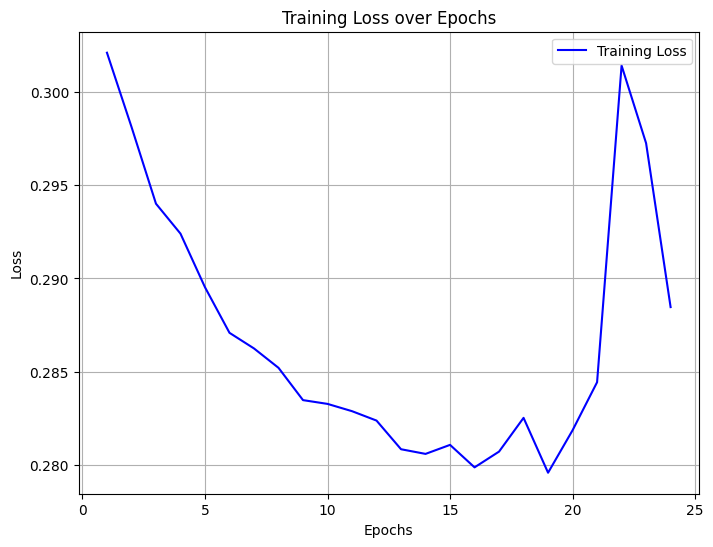

In [18]:
import matplotlib.pyplot as plt

loss = history.history['loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
print(history.history.keys())

dict_keys(['duration_loss', 'loss', 'pitch_loss', 'step_loss'])


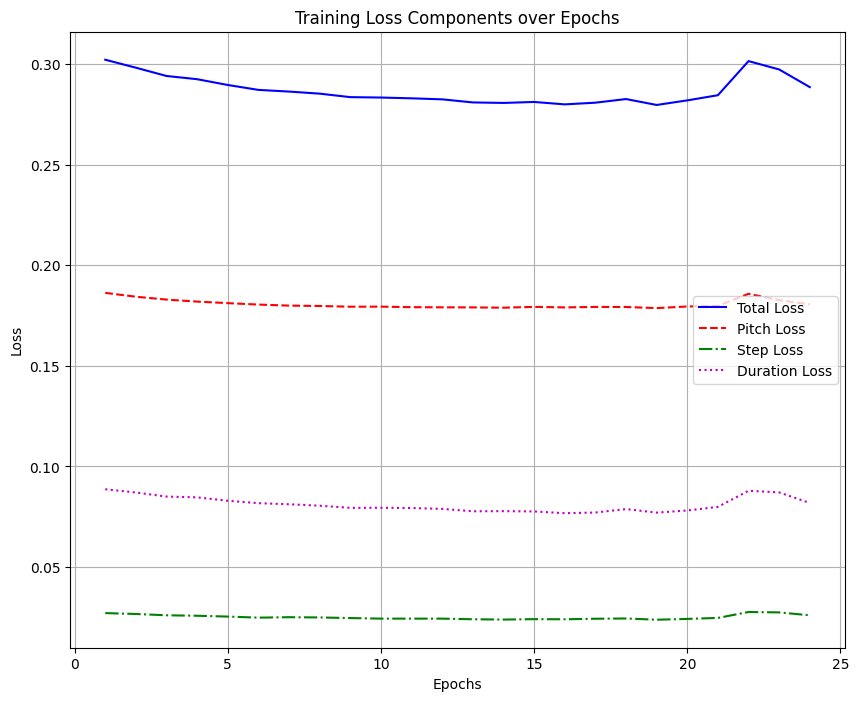

In [20]:
import matplotlib.pyplot as plt

history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(10, 8))

plt.plot(epochs, history_dict['loss'], 'b-', label='Total Loss')
plt.plot(epochs, history_dict['pitch_loss'], 'r--', label='Pitch Loss')
plt.plot(epochs, history_dict['step_loss'], 'g-.', label='Step Loss')
plt.plot(epochs, history_dict['duration_loss'], 'm:', label='Duration Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Components over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
def predict_next_note(notes: np.ndarray, keras_model: tf.keras.Model, 
                      temperature: float = 1.0) -> int:
    """Generates a note ID using a trained sequence model."""

    assert temperature > 0

    # Add batch dimension
    inputs = tf.expand_dims(notes, 0)

    predictions = keras_model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    # Debugging: print the raw outputs
    print(f"Predictions - Pitch logits: {pitch_logits}, Step: {step}, Duration: {duration}")

    # Apply temperature scaling to pitch logits
    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)

    # Apply temperature scaling to step and duration
    step /= temperature
    duration /= temperature

    # Ensure step and duration are non-negative
    step = tf.maximum(0.1, step)  # Minimum value of 0.1 to avoid zero
    duration = tf.maximum(0.1, duration)  # Minimum value of 0.1 to avoid zero

    # Debugging: print final values for step and duration
    print(f"Adjusted - Pitch: {pitch}, Step: {step}, Duration: {duration}")

    return int(pitch), float(step), float(duration)


In [22]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes while the pitch is normalized similar to training sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0

# Slowing down factor (adjust this to change the speed)
slowdown_factor = 2.0  # Increase this value to slow down the music

for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)

    # Apply the slowdown factor to step and duration
    step *= slowdown_factor
    duration *= slowdown_factor

    start = prev_start + step
    end = start + duration

    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start
generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

generated_notes.head(10)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Predictions - Pitch logits: [[-14.888483   -14.853626   -14.827692   -14.8769245  -14.83056
  -14.887875   -14.840038   -14.874894   -14.851903   -14.830975
  -14.8670635  -14.795201   -14.890263   -14.854721   -14.835596
  -14.820943   -14.865393   -14.859654   -14.838365   -14.852596
  -14.856167    -7.1843867   -6.0880704   -7.3693943   -5.822063
   -5.030547    -5.095626    -4.2016945   -3.1846786   -3.243598
   -2.9533608   -2.0505226   -2.2104855   -1.0055993   -2.2954907
   -1.4374675   -0.8063992   -0.0515652   -0.10912085   0.10995209
    0.20992789   0.39518338   0.60067374   1.440241     1.0988678
    1.6367962    1.2782711    1.7270966    1.9307317    2.3013806
    2.186422     1.8667961    2.227959     1.775573     1.4253362
    1.8068333    1.3046073    1.4088154    1.0042486    0.8007616
    0.2842474    0.6293233    0.6578598    0.37529576   0.55222106
    0.47866178   0.17170584   0.14241731  -0.14127743   0.30866838
   -0.0258157

,pitch,step,duration,start,end
0,72,0.2,0.2,0.2,0.4
1,89,0.2,0.2,0.4,0.6
2,84,0.2,0.2,0.6,0.8
3,89,0.2,0.2,0.8,1.0
4,89,0.2,0.2,1.0,1.2
5,86,0.2,0.2,1.2,1.4
6,89,0.2,0.2,1.4,1.6
7,84,0.2,0.2,1.6,1.8
8,91,0.2,0.2,1.8,2.0
9,91,0.2,0.2,2.0,2.2


In [23]:
out_file = 'output.midi'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)

In [24]:
from IPython.display import FileLink

FileLink(out_file)

/kaggle/working/output.midi

In [25]:
model.save('my_model.keras')